# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Download Input data set and Apply summary statistics

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True,  transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True,  transform=test_transforms)

In [4]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
train_data_mean = torch.mean(train_data)
train_data_std = torch.std(train_data)
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train_data_mean)
print(' - std:', train_data_std)
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/Users/vehere/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Data Transformation
performed 2 basic transformations
1. ToTensor
2. Normalize

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Display a single Digit from MNIST dataset

torch.Size([64, 1, 28, 28])
torch.Size([64])


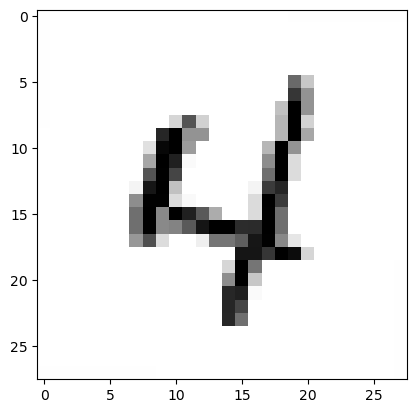

In [8]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Display an array of random images from dataset


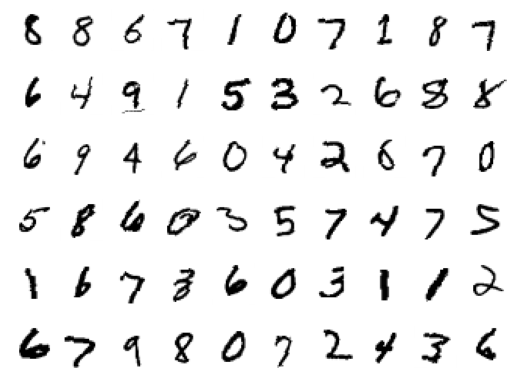

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
from model import Net5
use_cuda = torch.cuda.is_available()
device = torch.device(use_cuda if use_cuda else "cpu")
print(device)
model = Net5().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
           Dropout-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,168
       BatchNorm2d-5           [-1, 16, 28, 28]              32
           Dropout-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 12, 14, 14]           1,740
       BatchNorm2d-9           [-1, 12, 14, 14]              24
          Dropout-10           [-1, 12, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,744
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [-

/Users/vehere/ERA_V2/ERA_v2.0/s7/model.py:153: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and test Net5 model

In [12]:
device = torch.device("mps")
model =  Net5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.3118647038936615 Batch_id=937 Accuracy=91.40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:29<00:00, 32.33it/s]



Test set: Average loss: 0.0634, Accuracy: 9822/10000 (98.22%)

EPOCH: 1


Loss=0.014599395915865898 Batch_id=937 Accuracy=97.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 44.90it/s]



Test set: Average loss: 0.0363, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.12817887961864471 Batch_id=937 Accuracy=97.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 44.95it/s]



Test set: Average loss: 0.0434, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.03027014434337616 Batch_id=937 Accuracy=97.93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 48.81it/s]



Test set: Average loss: 0.0376, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.2804780602455139 Batch_id=937 Accuracy=98.14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.81it/s]



Test set: Average loss: 0.0322, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.009851638227701187 Batch_id=937 Accuracy=98.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 49.24it/s]



Test set: Average loss: 0.0305, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.0069057755172252655 Batch_id=937 Accuracy=98.39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.38it/s]



Test set: Average loss: 0.0273, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.2707911431789398 Batch_id=937 Accuracy=98.52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.22it/s]



Test set: Average loss: 0.0281, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.007759976666420698 Batch_id=937 Accuracy=98.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 48.31it/s]



Test set: Average loss: 0.0295, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.010206658393144608 Batch_id=937 Accuracy=98.62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 48.54it/s]



Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.0028347112238407135 Batch_id=937 Accuracy=98.58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.75it/s]



Test set: Average loss: 0.0226, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.04707027226686478 Batch_id=937 Accuracy=98.68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 44.99it/s]



Test set: Average loss: 0.0216, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.00047465271200053394 Batch_id=937 Accuracy=98.70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.19it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.0014292077394202352 Batch_id=937 Accuracy=98.76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.89it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.03134981915354729 Batch_id=937 Accuracy=98.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.20it/s]



Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.00470336340367794 Batch_id=937 Accuracy=98.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.64it/s]



Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.0014391490258276463 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.29it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.02484271489083767 Batch_id=937 Accuracy=98.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 46.02it/s]



Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.037220560014247894 Batch_id=937 Accuracy=98.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 48.15it/s]



Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.01671867072582245 Batch_id=937 Accuracy=98.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 46.68it/s]



Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)



# Train Vs Test Loss Plot

In [13]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

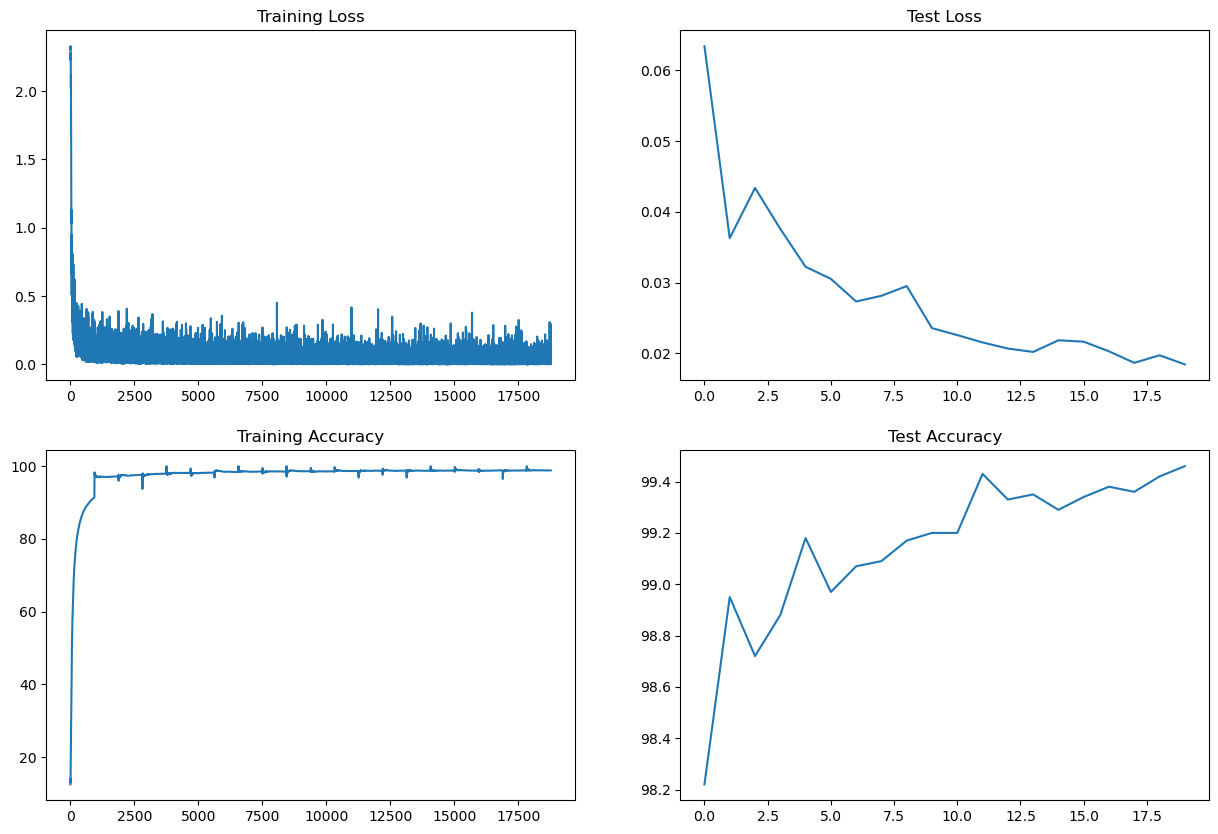

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
* Create light weight model (Net4) with lesser paramerter(14.5k) than basic Model(Net3). <br>
* Introduce Drop out of 0.3 after every convolution transition block. <br>
## Results:
* Parameters: 12,122 <br>
* Best Training Accuracy: 98.76 <br>
* Best Test Accuracy: 99.43 <br>
## Analysis:
* Net5 is roubust light weight model with 12,122 parameters and consistently produced test accuracy of ~ 99.35 to 99.43% in multiple epochs.<br>
* After added dropout, the overfitting problem was resolved, the max training accuracy is 99.43% and there is scope for additional improvement in training and to increase test accuracy further.<br>